In [10]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Salary Prediction

This is a very basic dataset based on the paper from Ron Kohavi *"Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996*. The task is simple, just predict if someone is above or below 50k$.

Please check more on the original page where the data is downloaded from [here](https://www.openml.org/d/1590).

## Downloading data

In [1]:
import os
data_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

fname = data_dir+"/1_salary_prediction.csv"
if not os.path.exists(fname):
    !wget -O $fname "https://www.openml.org/data/get_csv/1595261/phpMawTba.csv"

## Importing modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#this is to set the style of our plots on seaborn
sns.set(style='ticks', context='notebook', palette='deep')
#sns.set_palette("BuGn_r")

## Data exploration

Here we'll try to understand a little bit of the dataset with some plots and basic analysis

In [3]:
df = pd.read_csv(fname)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
df.shape

(48842, 15)

There are 15 features and 48842 rows in our dataset. Let's see which of this features are categorical which ones numerical.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education-num     48842 non-null int64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null object
class             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


And a description for the numerical:

In [6]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Let's try to see how many classes do we have per each feature. That is for instance, how many countries are there in the *native-country* feature?

In [7]:
categorical_classes = ["workclass",
                 "education",
                 "marital-status",
                 "occupation",
                 "relationship",
                 "race",
                 "sex",
                 "native-country",
                 "class"]

tmp = df.copy() #create a separated copy from df
tmp = tmp.loc[:,categorical_classes] #subset cat classes
tmp = tmp.apply(lambda x: len(x.unique())) #count unique classes per feature

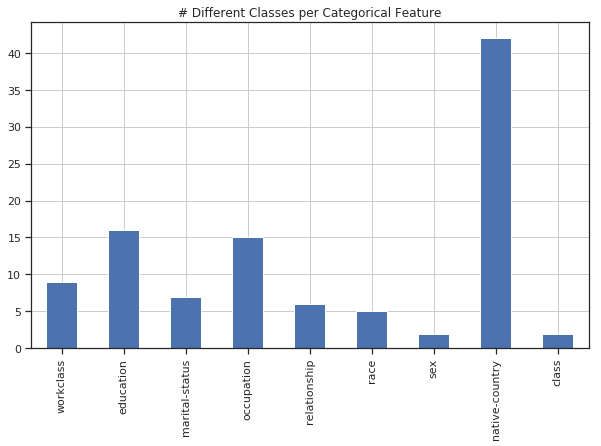

In [8]:
tmp.plot(kind = "bar",
         grid=True,
         title = "# Different Classes per Categorical Feature",
         figsize = (10,6))
plt.show()

We see there are many native countries very different ocupation and education. Let's see what are these values briefly.

<Figure size 432x288 with 0 Axes>

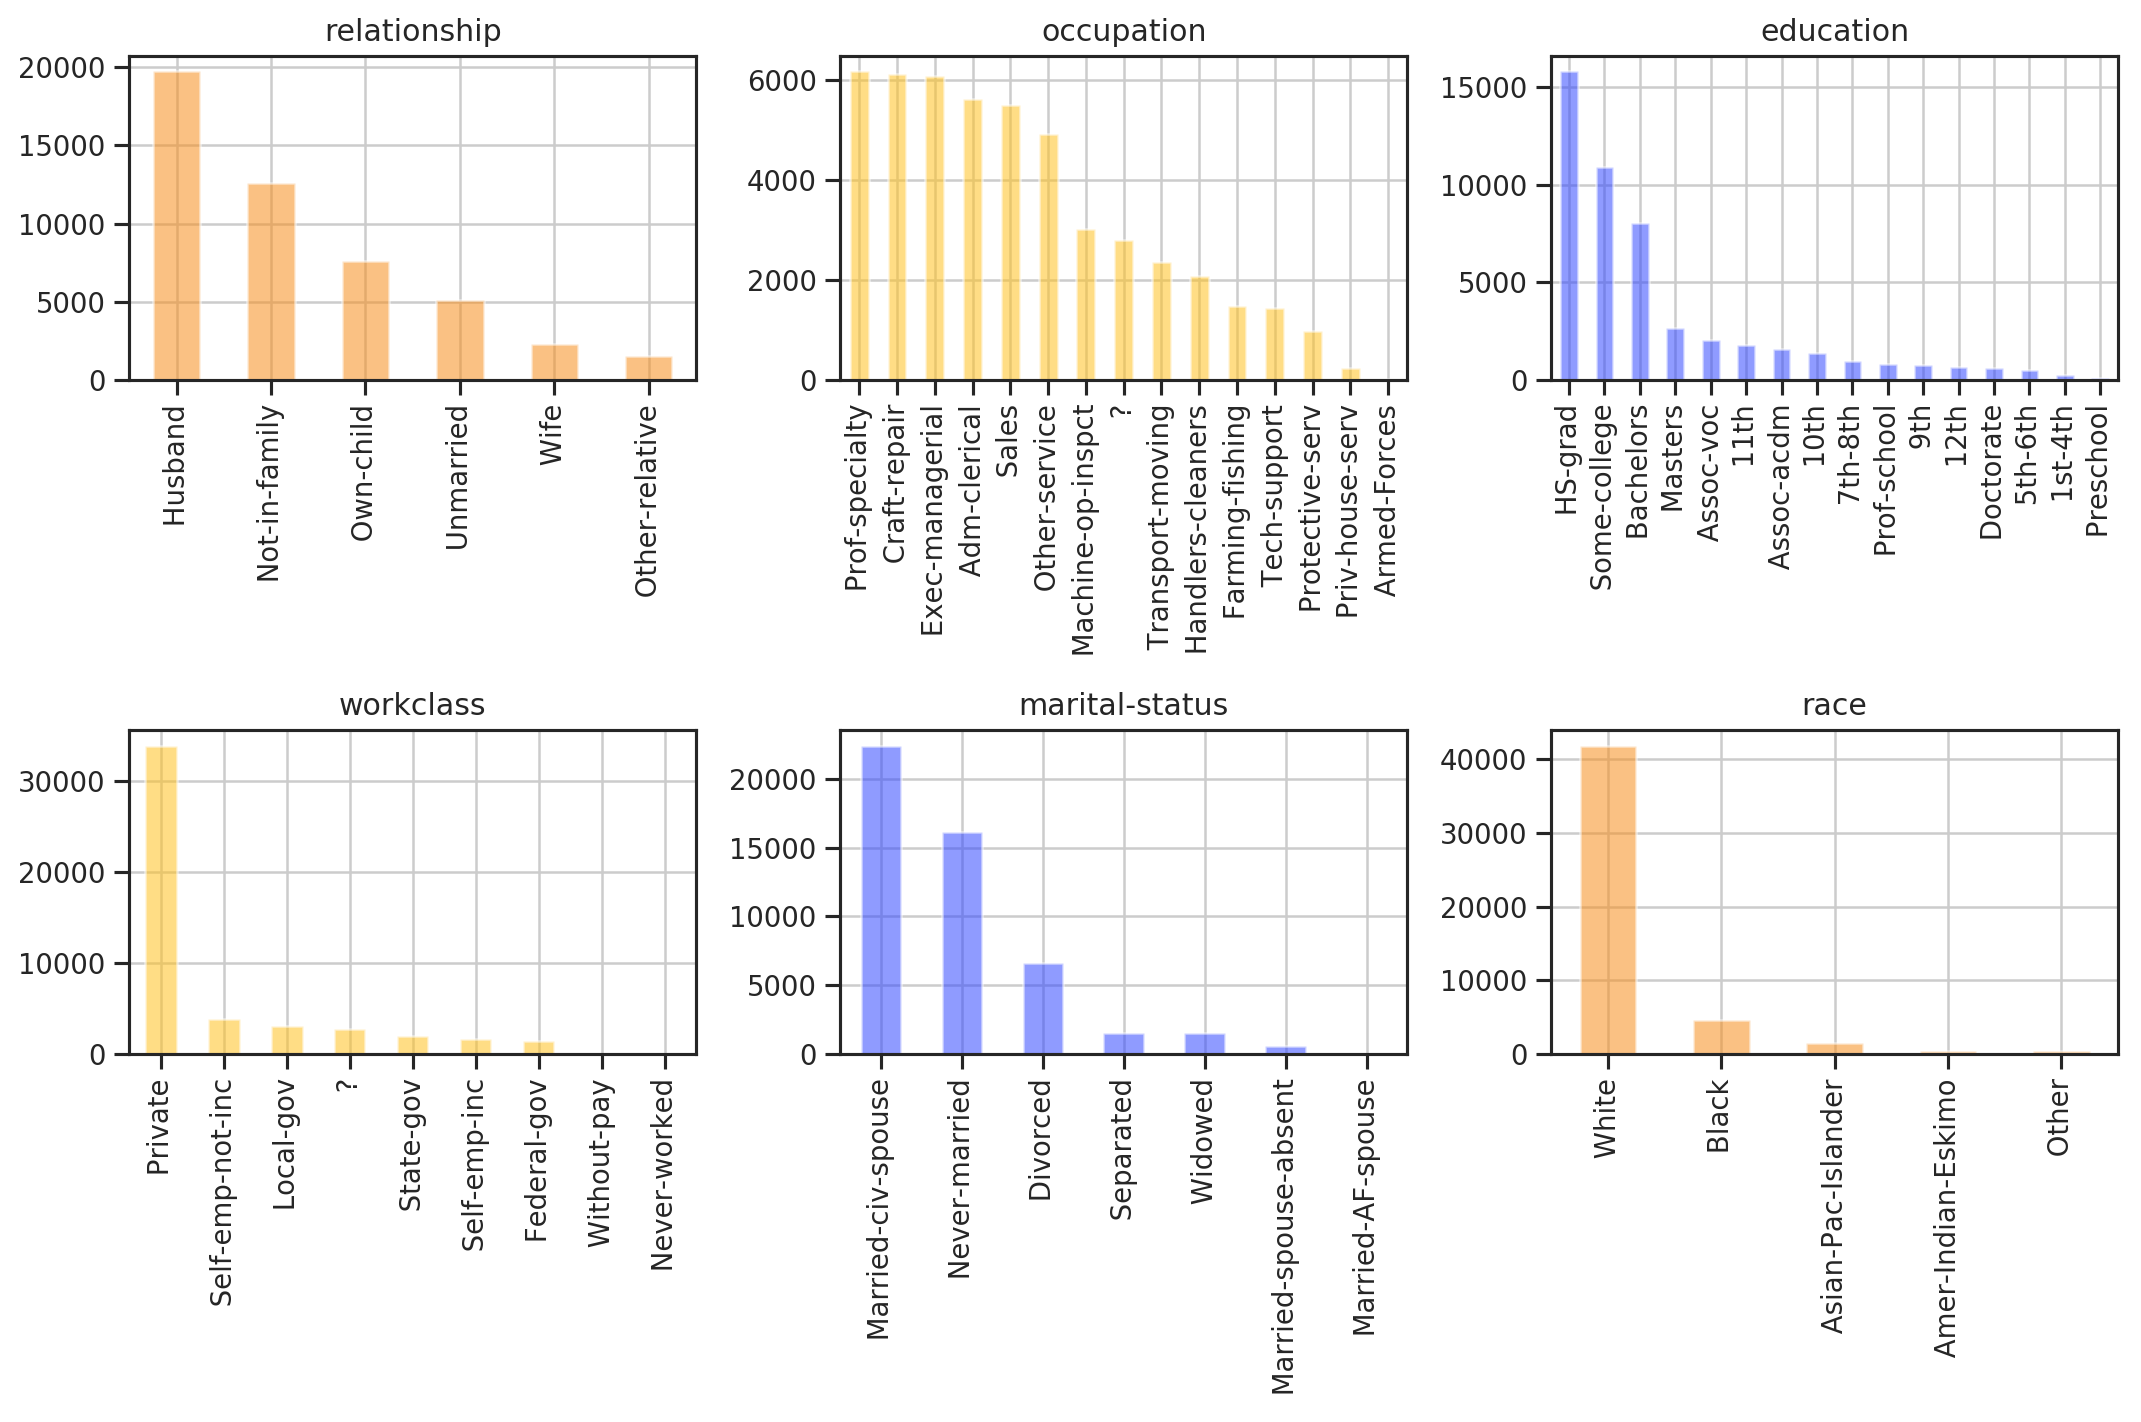

In [9]:
plt.clf()
def plot_hitograms(df,fields,colors,ncol,nrow):
    fig=plt.figure(dpi = 180, figsize=(12,8))
    for i,var_name in enumerate(fields):
        ax=fig.add_subplot(nrow,ncol,i+1)
        df[var_name].value_counts().plot(kind="bar",ax=ax,color =colors[i],alpha =0.55)
        ax.set_title(var_name)
        ax.grid()
    fig.tight_layout()  # Improves appearance a bit.
    
    plt.show()
    
plot_hitograms(df,fields = ["relationship","occupation","education","workclass","marital-status","race"],
               colors = ['#F78F1E','#FFC222','#3349FF','#FFC222','#3349FF','#F78F1E','#FFC222'],
               ncol = 3,
               nrow = 2)

In [10]:
df.loc[:,"sex"].value_counts().iloc[0:15]

 Male      32650
 Female    16192
Name: sex, dtype: int64

Interestingly most of the interviewees are husband or not in family, wifes are much less represented. It is weird that back in 1996 there was this huge sex balance but it is possible. Most of the people is professional and we have very few in the armed forces. As of education lots of high-school grads followed by people having attended college and bachelors. Not many people with PhD's!. Workclass, mostly people work in private this feature won't give us much information. There is a huge bias in race and sex, most of people is white and 2/3 of the population are male.

In [11]:
df.loc[:,"native-country"].value_counts().iloc[0:15]

 United-States    43832
 Mexico             951
 ?                  857
 Philippines        295
 Germany            206
 Puerto-Rico        184
 Canada             182
 El-Salvador        155
 India              151
 Cuba               138
 England            127
 China              122
 South              115
 Jamaica            106
 Italy              105
Name: native-country, dtype: int64

Most of our interviewees are from the US, this feature will tell us very few information. Let's now have a look on the numerical data

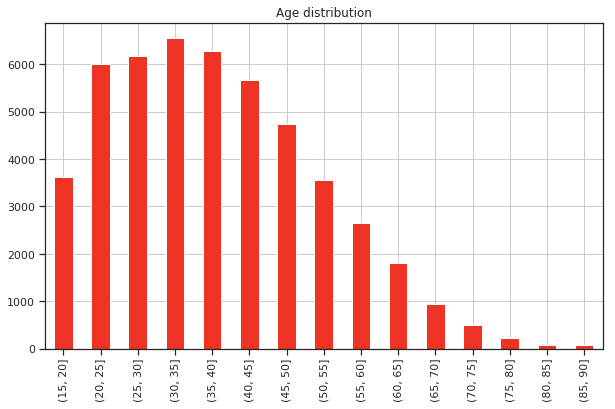

In [18]:
#first we create the bins, in our case partition the age from 0 to 125 in steps of 5
bins = list(range(15,95,5))
#then we name the bins, we can say the same but converting them to string
group_names = list(map(str,bins))
tmp = df.copy()
tmp['age_bin'] = pd.cut(tmp['age'], bins)

plt.clf()
plt.title("Age distribution")
tmp.age_bin.value_counts().sort_index().plot(kind = "bar",
                                             color = '#EE3224',
                                             figsize = (10,6),
                                             grid = True)
plt.show()

Age is interesting, most of the people lay in between 20 and 50, then the number of people starts to decrease. Could it be because early retirement?. Also wha is this people above 70 working? They could be outliers I suspect...

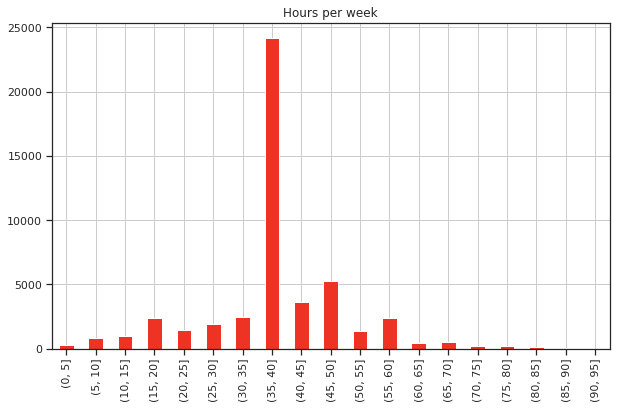

In [19]:
bins = list(range(0,100,5))
#then we name the bins, we can say the same but converting them to string
group_names = list(map(str,bins))
tmp = df.copy()
tmp['hours_per_week_bin'] = pd.cut(tmp['hours-per-week'], bins)

plt.clf()
plt.title("Hours per week")
tmp.hours_per_week_bin.value_counts().sort_index().plot(kind = "bar",
                                             color = '#EE3224',
                                             figsize = (10,6),
                                             grid = True)
plt.show()

This is more normal, most of the people lay in between 35 to 40 hours per week which is a regular 7-8 hours per day. Some people work even longer hours, we have peaks at 40-45 and 45-50. Then the numbers start do decrase (as it should be...). Those who work less may be part time jobs, maybe young students?.